### Imports

In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import seaborn
seaborn.set()

In [3]:
conn = sqlite3.connect('babar_tables')

sql_customer = pd.read_sql_query('''SELECT * FROM babar_server_customer''', conn)
sql_product = pd.read_sql_query('''SELECT * FROM babar_server_product''', conn)
sql_purchase = pd.read_sql_query('''SELECT * FROM babar_server_purchase''', conn)

### Format data

In [4]:
df_customer = pd.DataFrame(sql_customer)
df_product = pd.DataFrame(sql_product)
df_purchase = pd.DataFrame(sql_purchase)

In [56]:
df = df_purchase[['amount', 'customer_id', 'product_id']].merge(df_customer[['id', 'nickname', 'year']], how='left', left_on='customer_id', right_on='id')

In [69]:
df.tail(5)

,amount,customer_id,product_id,id,nickname,year
172367,2.0,2138,294,2138,La ptite gelÃ©e,2025
172368,2.0,1917,222,1917,Benjit,2024
172369,2.0,2075,222,2075,Salade,2025
172370,2.0,2075,222,2075,Salade,2025
172371,2.5,2044,287,2044,Mali,2024


### Short analysis

In [78]:
# analyze those who are linked with bar
#df_customer.groupby('status_id').agg({'id' : 'count'}).sort_values(by=['status_id'])

In [91]:
cust = df_customer.groupby('year').agg({'id' : 'count'})
prod = df_product.groupby('price').agg({'id' : 'count'})

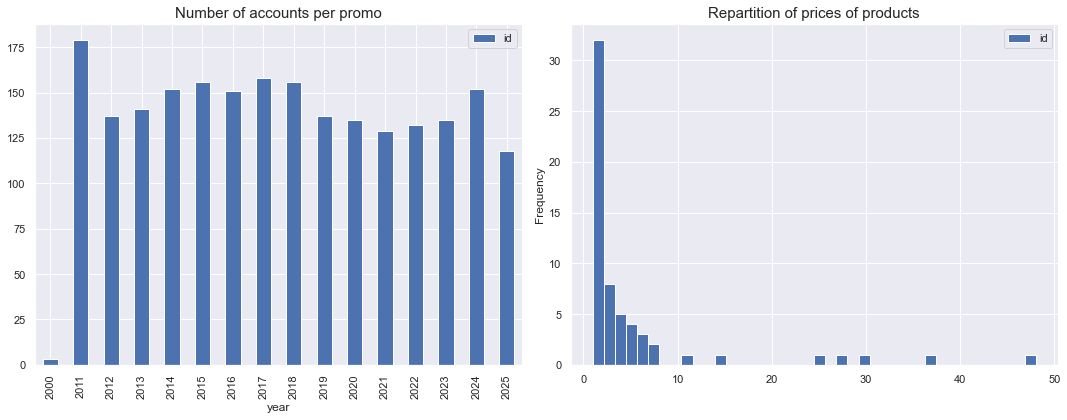

In [98]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))

cust.plot(kind='bar', ax=ax1)
ax1.set_title('Number of accounts per promo', fontsize = 15)

prod.plot(kind='hist', ax=ax2, bins = 40)
ax2.set_title('Repartition of prices of products', fontsize = 15)

plt.tight_layout()
plt.show()

### Rankings

In [63]:
df_ranking_product = df.groupby('product_id').agg({'amount' : 'sum'}).sort_values(by=['amount'])
df_ranking_customer = df.groupby('customer_id').agg({'amount' : 'sum'}).sort_values(by=['amount'])
df_ranking_promo = df.groupby('year').agg({'amount' : 'sum'})

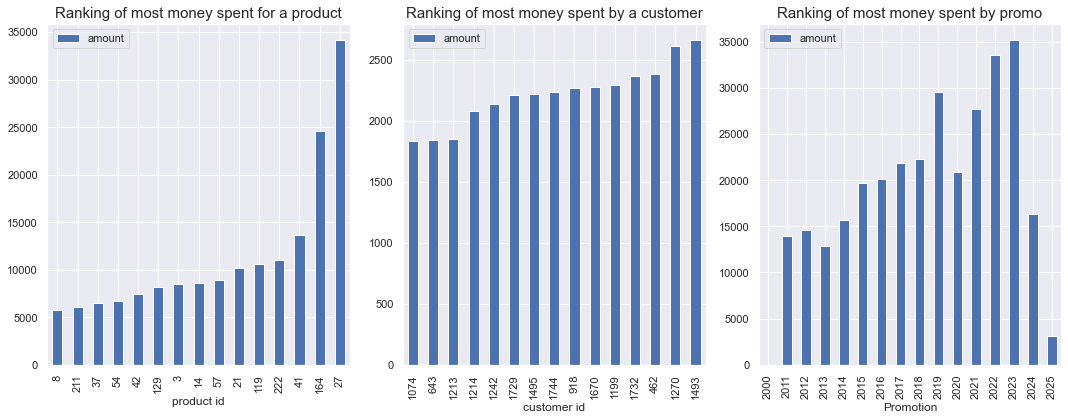

In [67]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))

df_ranking_product[-15:].plot(kind='bar', ax=ax1)
ax1.set_title('Ranking of most money spent for a product', fontsize = 15)
ax1.set_xlabel('product id')

df_ranking_customer[-15:].plot(kind='bar', ax=ax2)
ax2.set_title('Ranking of most money spent by a customer', fontsize = 15)
ax2.set_xlabel('customer id')

df_ranking_promo.plot(kind='bar', ax=ax3)
ax3.set_title('Ranking of most money spent by promo', fontsize = 15)
ax3.set_xlabel('Promotion')

plt.tight_layout()
plt.show()

In [ ]:
# TODO : add count insted of sum 

In [70]:
# TODO : add proportion of people that are in the bar

### Analysis stronger and better quality beer

TODO : 
- create a dataframe beer : 
    - keep only this beverage
    - add percentage
    - add quantity
    - categorize low price vs. medium price
    - add ratio : price/vol and alchol/vol

- analysis
    - evolution of ratios
    

### Analysis stronger and better quality beer

- segment per hour
- see how to create graph according to dataset
- create link if two people drank at same hour (weight of link = number of drinks shared)

### Time series analysis